# Benchmark stats


This notebook has to be executed after [benchmark.ipynb](benchmark.ipynb) to generate its latex array.


In [11]:
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
import numpy as np

from pathlib import Path
from typing import *

# Graph

In [21]:
import numpy as np
import json
import glob
import os
import matplotlib.pyplot as plt


def get_success_rate(distance_list,treshold_interval = [0,1], mode="greater"):
    treshold = np.linspace(treshold_interval[0], treshold_interval[1])
    if mode == "greater":
        res = np.array([len(distance_list[distance_list > t]) for t in treshold])
    else :
        res = np.array([len(distance_list[distance_list < t]) for t in treshold])
    return res / len(distance_list)

# get AUC for one model and all video
def get_average_success(benchmark, mode="iou"):
    if mode == "iou": # success mode (iou) -> treshold vary between 0 and 1
        res = np.array([get_success_rate(video, treshold_interval = [0,1], mode="greater") for video in benchmark])
    else: # precision mode (euclidean distance between bbox centers) -> treshold vary between 0 and 50 
        res = np.array([get_success_rate(video, treshold_interval = [0,50], mode="lower") for video in benchmark])
    return np.mean(res.T, axis=1)

# get AUC for all model and all videos
def get_benchmark_curves(benchmarks, mode="iou"):
    res = {}
    for model in benchmarks:
        res[model] = get_average_success(benchmarks[model], mode=mode)
    return res

# get distance list for one model and all videos
def get_benchmark_from_json(json_path, mode="iou"):
    with open(json_path, 'r') as f:
        data = json.load(f)
    video_list = data.keys()
    key = "scores" if mode == "iou" else "precisions"
    return [np.array(data[video][key]) for video in video_list]

def get_models_benchmark_from_json(directory, dataset="mytc128", mode="iou"):
    benchmarks = {}
    filename = dataset+".json"
    for dir in os.listdir(directory):
        if os.path.exists(os.path.join(directory,dir,filename)):
            benchmarks[dir] = get_benchmark_from_json(os.path.join(directory,dir,filename), mode=mode)
    return benchmarks

def get_models_curves(directory, dataset="mytc128", mode="iou"):
    benchmarks = get_models_benchmark_from_json(directory, dataset, mode)
    return get_benchmark_curves(benchmarks, mode=mode)

def plot_curves_dataset(directory, dataset):
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(15, 6)

    def plot_curve(ax, title, mode):
        curves = get_models_curves("results", dataset, mode)
        x = np.linspace(0,1) if mode == "iou" else np.linspace(0,50)
        for model in curves:
            ax.plot(x, curves[model], label=model)
        ax.set_title(title)
        ax.legend()
        ax.set_ylim(0,1)

    plot_curve(ax[0], "Success rate", mode="iou")
    plot_curve(ax[1], "Precision", mode="distance")

    plt.savefig(f"results_{dataset}.png")
    plt.show()

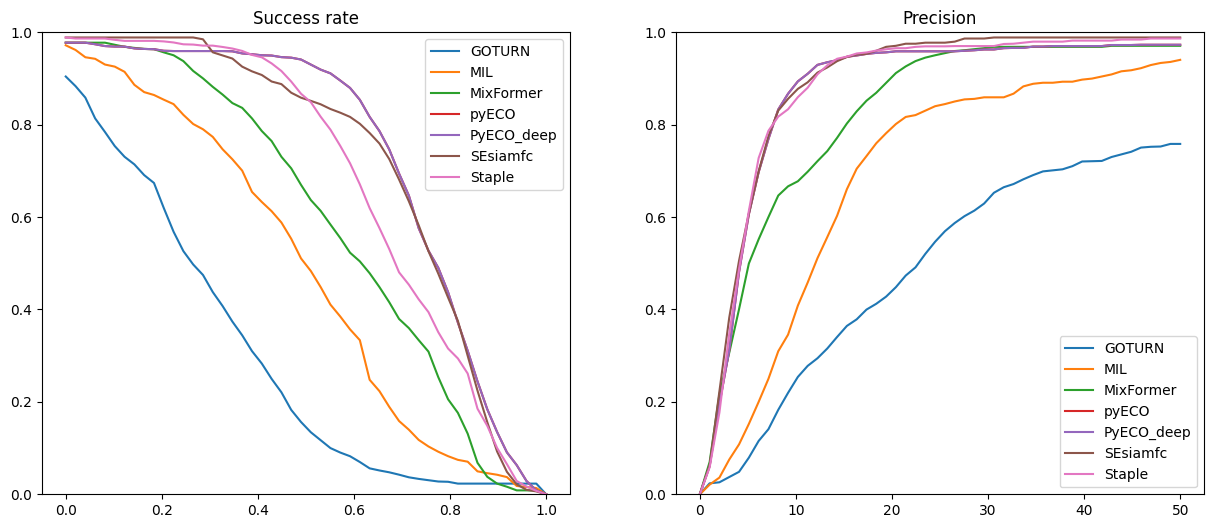

In [22]:
plot_curves_dataset("results", "mytc128")

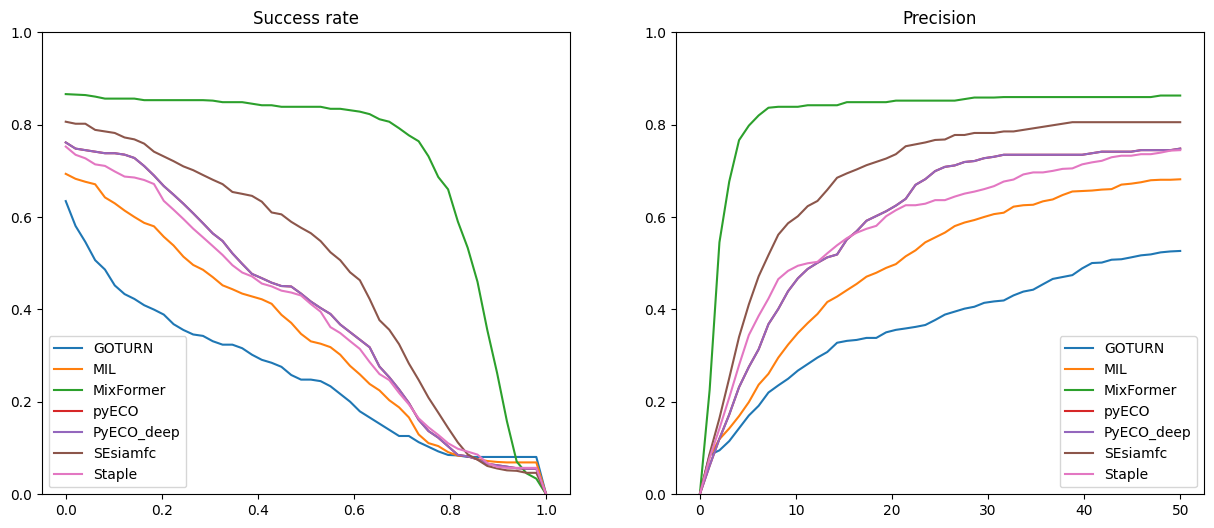

In [23]:
plot_curves_dataset("results", "myvot2021")

# Latex table

In [2]:
def get_results() -> Dict:
    """Get results from the results folder."""
    res: Dict = {}
    result_folder = Path("results")

    for tracker in result_folder.iterdir():
        res[tracker.name] = {}
        for dataset in tracker.iterdir():
            with open(dataset) as f:
                res[tracker.name][dataset.name[:-5]] = json.load(f)
    return res

results: Dict = get_results()

In [3]:
def get_stats(results: Dict, metrics=["precision", "succes", "fps", "lost"]):
    stats: Dict = {}

    for tracker in results:
        stats[tracker] = {}

        for dataset in results[tracker]:
            for metric in metrics:

                cur: List[float] = []
                for seq in results[tracker][dataset]:
                    cur.append(results[tracker][dataset][seq][metric])

                stats[tracker][(dataset, metric)] = [
                    f"{np.mean(cur):3.2f} ({np.std(cur):3.2f})"
                ]

    return stats

In [4]:
stats = get_stats(results)
stats

KeyError: 'precision'

In [17]:
df = pd.DataFrame(list(stats.values())[0], index=[list(stats.keys())[0]])
for i in range(1, len(stats)):
    df = df.append(pd.DataFrame(list(stats.values())[i], index=[list(stats.keys())[i]]))
df

/tmp/ipykernel_3151/1517688541.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(list(stats.values())[i], index=[list(stats.keys())[i]]))
/tmp/ipykernel_3151/1517688541.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(list(stats.values())[i], index=[list(stats.keys())[i]]))
/tmp/ipykernel_3151/1517688541.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(list(stats.values())[i], index=[list(stats.keys())[i]]))
/tmp/ipykernel_3151/1517688541.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(list(stats.values())[i], inde

mytc128                                            myvot2021  \
              precision       succes           fps         lost    precision   
AAA         0.78 (0.00)  0.88 (0.00)   1.13 (0.00)  1.00 (0.00)  0.39 (0.00)   
MIL         0.59 (0.00)  0.56 (0.00)  11.80 (0.00)  1.00 (0.00)  0.36 (0.00)   
MixFormer   0.72 (0.00)  0.87 (0.00)   7.62 (0.00)  2.00 (0.00)  0.67 (0.00)   
PyECO       0.79 (0.00)  0.91 (0.00)   6.63 (0.00)  2.00 (0.00)  0.39 (0.00)   
PyECO_deep  0.79 (0.00)  0.91 (0.00)   6.71 (0.00)  2.00 (0.00)  0.39 (0.00)   
SEsiamfc    0.78 (0.00)  0.91 (0.00)   2.25 (0.00)  1.00 (0.00)  0.45 (0.00)   
Staple      0.80 (0.00)  0.91 (0.00)  15.66 (0.00)  1.00 (0.00)  0.31 (0.00)   

                                                    
                 succes           fps         lost  
AAA         0.54 (0.00)   1.40 (0.00)  7.00 (0.00)  
MIL         0.60 (0.00)  21.59 (0.00)  6.00 (0.00)  
MixFormer   0.83 (0.00)   8.45 (0.00)  3.00 (0.00)  
PyECO       0.55 (0.00)   5.11 (0.00)  7.00 (0.00)  
PyECO_deep  0.55 (0.00)   5.35 (0.00)  7.00 (0.00)  
SEsiamfc    0.66 (0.00)   7.22 (0.00)  4.00 (0.00)  
Staple      0.40 (0.00)  33.41 (0.00)  6.00 (0.00)

In [18]:
txt = df.style.to_latex(
    position="!ht",
    multicol_align="l",
    multirow_align="l",
    caption="Results of the benchmarks",
)

txt.replace('_', '\_')

print(txt)

\begin{table}[!ht]
\caption{Results of the benchmarks}
\begin{tabular}{lllllllll}
 & \multicolumn{4}{l}{mytc128} & \multicolumn{4}{l}{myvot2021} \\
 & precision & succes & fps & lost & precision & succes & fps & lost \\
AAA & 0.78 (0.00) & 0.88 (0.00) & 1.13 (0.00) & 1.00 (0.00) & 0.39 (0.00) & 0.54 (0.00) & 1.40 (0.00) & 7.00 (0.00) \\
MIL & 0.59 (0.00) & 0.56 (0.00) & 11.80 (0.00) & 1.00 (0.00) & 0.36 (0.00) & 0.60 (0.00) & 21.59 (0.00) & 6.00 (0.00) \\
MixFormer & 0.72 (0.00) & 0.87 (0.00) & 7.62 (0.00) & 2.00 (0.00) & 0.67 (0.00) & 0.83 (0.00) & 8.45 (0.00) & 3.00 (0.00) \\
PyECO & 0.79 (0.00) & 0.91 (0.00) & 6.63 (0.00) & 2.00 (0.00) & 0.39 (0.00) & 0.55 (0.00) & 5.11 (0.00) & 7.00 (0.00) \\
PyECO_deep & 0.79 (0.00) & 0.91 (0.00) & 6.71 (0.00) & 2.00 (0.00) & 0.39 (0.00) & 0.55 (0.00) & 5.35 (0.00) & 7.00 (0.00) \\
SEsiamfc & 0.78 (0.00) & 0.91 (0.00) & 2.25 (0.00) & 1.00 (0.00) & 0.45 (0.00) & 0.66 (0.00) & 7.22 (0.00) & 4.00 (0.00) \\
Staple & 0.80 (0.00) & 0.91 (0.00) & 15.66 (